In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/My_drive/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv
/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00005.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00057.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00020.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00072.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00040.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00043.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00010.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00071.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/image

/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00023.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00020.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00095.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00011.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00051.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00008.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00027.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00032.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00066.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00078.png
/kaggle/input/gtzan-dataset-mu

/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00043.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00076.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00036.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00063.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00097.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00075.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00056.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00010.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00084.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00072.png
/kaggle/in

/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00047.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00021.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00031.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00095.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00012.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00027.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00049.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00088.wav
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00054.wav
/kaggle/input/gtzan-dataset-music-genre-classi

In [2]:
#extracting the data
  
import json
import os
import math
import librosa
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATASET_PATH = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/"
JSON_PATH = "audio_mfcc_features.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [3]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    
    """
    Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT(Fast Fourier Transformation). Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path: 
            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
            
            # process all audio files in genre sub-dir
            for f in filenames:
                # load audio file
                if f != "jazz.00054.wav":
                    file_path = os.path.join(dirpath, f)
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        mfcc = librosa.feature.mfcc( signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                           # print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: disco

Processing: metal

Processing: reggae

Processing: blues

Processing: rock

Processing: classical

Processing: jazz

Processing: hiphop

Processing: country

Processing: pop


In [4]:
JSON_DATA_PATH='../working/audio_mfcc_features.json'

In [5]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [6]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(JSON_DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [7]:
# Building the RNN_LSTM Model
def build_model(input_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [8]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [9]:
print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape)

(5991, 130, 13) (1498, 130, 13) (2497, 130, 13) (5991,) (1498,) (2497,)


In [10]:
 # create network
input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


In [11]:
 # train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
188/188 [==============================] - 24s 129ms/step - loss: 2.1978 - accuracy: 0.2117 - val_loss: 2.0554 - val_accuracy: 0.2824
Epoch 2/30
188/188 [==============================] - 23s 124ms/step - loss: 1.9344 - accuracy: 0.3223 - val_loss: 1.7830 - val_accuracy: 0.3845
Epoch 3/30
188/188 [==============================] - 24s 126ms/step - loss: 1.7161 - accuracy: 0.3986 - val_loss: 1.6026 - val_accuracy: 0.4513
Epoch 4/30
188/188 [==============================] - 23s 123ms/step - loss: 1.6071 - accuracy: 0.4365 - val_loss: 1.4964 - val_accuracy: 0.4740
Epoch 5/30
188/188 [==============================] - 24s 126ms/step - loss: 1.4996 - accuracy: 0.4729 - val_loss: 1.4158 - val_accuracy: 0.4826
Epoch 6/30
188/188 [==============================] - 24s 125ms/step - loss: 1.4516 - accuracy: 0.4836 - val_loss: 1.3778 - val_accuracy: 0.5100
Epoch 7/30
188/188 [==============================] - 23s 125ms/step - loss: 1.4071 - accuracy: 0.5008 - val_loss: 1.3471 - val_ac

Text(0.5, 1.0, 'Accuracy eval')

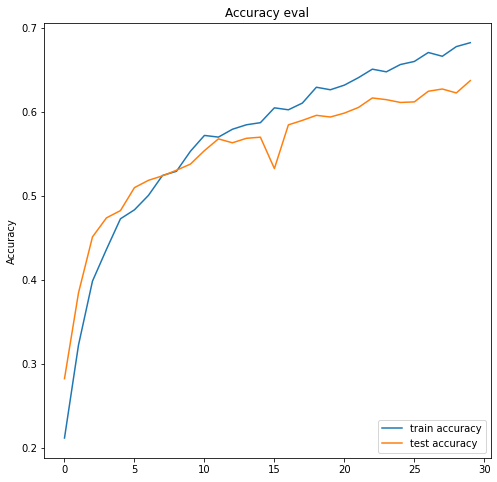

In [14]:
# plot accuracy/error for training and validation 
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)

# create accuracy sublpot
ax.plot(history.history["accuracy"], label="train accuracy")
ax.plot(history.history["val_accuracy"], label="test accuracy")
ax.set_ylabel("Accuracy")
ax.legend(loc="lower right")
ax.set_title("Accuracy eval")


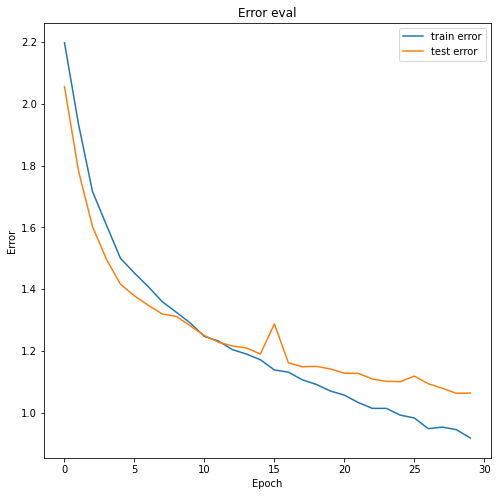

In [15]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
# create error sublpot
ax.plot(history.history["loss"], label="train error")
ax.plot(history.history["val_loss"], label="test error")
ax.set_ylabel("Error")
ax.set_xlabel("Epoch")
ax.legend(loc="upper right")
ax.set_title("Error eval")

plt.show() 

In [16]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 3s - loss: 1.1088 - accuracy: 0.6260

Test accuracy: 0.6259511709213257


Summary:

By looking into training and test accuracy as well as loss plots,we observe that RNN_LSTM has tried to learn the data well and also tried to reduce the overfitting issue. The accuracy for test dataset is achieved nearly 62.5% and training is 63.7% which is good because it reduces overfitting problem and generalises the learning in the test data.

We have extracted MFCC vectors from audio data and used them as input to RNN with LSTM model to predict genre for unseen audio data.

We can say that RNN with LSTM model has provide reliable results as compared to the other earlier trained models.

In [19]:
#direct saving 
model.save('my_model.h5') 

In [20]:
#load model 
from keras.models import load_model
model = load_model('my_model.h5')

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
None
